In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Dividir training i test

In [90]:
# Carregar el CSV en un DataFrame
df_full = pd.read_csv("ObesityDataSet.csv", encoding="utf-8")

# Mostrar les primeres files
df_full



,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [91]:
# Dividir les dades en train i test
X = df_full[[col for col in df_full.columns if col != 'NObeyesdad']]
y = df_full['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

y_train

1994       Obesity_Type_III
17           Obesity_Type_I
206          Obesity_Type_I
1944       Obesity_Type_III
1198    Overweight_Level_II
               ...         
1560        Obesity_Type_II
162           Normal_Weight
609     Insufficient_Weight
1718        Obesity_Type_II
470           Normal_Weight
Name: NObeyesdad, Length: 1794, dtype: object

## Explortory data analysis

In [92]:
df_split = pd.concat([X_train, y_train], axis=1)
df_split


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1994,Female,21.282238,1.748951,133.662583,yes,yes,3.000000,3.000000,Sometimes,no,2.247979,no,1.609938,0.849236,Sometimes,Public_Transportation,Obesity_Type_III
17,Female,29.000000,1.530000,78.000000,no,yes,2.000000,1.000000,Sometimes,no,2.000000,no,0.000000,0.000000,no,Automobile,Obesity_Type_I
206,Male,19.000000,1.750000,100.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,2.000000,0.000000,no,Public_Transportation,Obesity_Type_I
1944,Female,21.051982,1.729719,131.877558,yes,yes,3.000000,3.000000,Sometimes,no,1.422483,no,1.708971,0.673009,Sometimes,Public_Transportation,Obesity_Type_III
1198,Male,18.000000,1.750097,86.372141,yes,yes,2.907062,3.000000,Sometimes,no,2.740848,no,1.219827,0.037634,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1560,Male,25.300208,1.765258,114.330023,yes,yes,1.562804,3.000000,Sometimes,no,2.075493,no,1.553734,0.000436,Sometimes,Public_Transportation,Obesity_Type_II
162,Female,21.000000,1.630000,60.000000,yes,yes,3.000000,3.000000,Always,yes,2.000000,no,2.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
609,Male,19.979810,1.753360,54.997374,yes,yes,2.000000,3.494849,Sometimes,no,2.976672,no,1.949070,2.000000,no,Public_Transportation,Insufficient_Weight
1718,Male,25.879411,1.765464,114.144378,yes,yes,1.626369,3.000000,Sometimes,no,2.109697,no,1.352973,0.076693,Sometimes,Public_Transportation,Obesity_Type_II


In [93]:
print(df_split.describe())

               Age       Height       Weight         FCVC          NCP  \
count  1794.000000  1794.000000  1794.000000  1794.000000  1794.000000   
mean     24.283944     1.702314    86.580621     2.426377     2.682923   
std       6.339740     0.093515    25.997022     0.529187     0.777583   
min      14.000000     1.456346    39.000000     1.000000     1.000000   
25%      19.899719     1.629550    65.934516     2.000000     2.656871   
50%      22.762612     1.701609    83.231077     2.398408     3.000000   
75%      26.000000     1.770000   107.087496     3.000000     3.000000   
max      61.000000     1.980000   160.639405     3.000000     4.000000   

              CH2O          FAF          TUE  
count  1794.000000  1794.000000  1794.000000  
mean      2.016808     1.016984     0.652431  
std       0.612781     0.845354     0.601616  
min       1.000000     0.000000     0.000000  
25%       1.607680     0.131685     0.000000  
50%       2.000000     1.000000     0.619850  
75% 

In [94]:
print("Número d'atributs del dataset:", len(df_split.keys()))
print("Número de files en el train (mostres): ",df_split.shape[0])

Número d'atributs del dataset: 17
Número de files en el train (mostres):  1794


In [95]:
# Mirem valors NaN per atribut
nan_counts = df_split.isna().sum()
var_type = df_split.dtypes
# Mostrem una taula amb els valors NaN i el tipus de variable
print("Valors NaN per atribut i tipus de variable:")
print(pd.DataFrame({"NaN Count": nan_counts, "Variable Type": var_type}))

Valors NaN per atribut i tipus de variable:
                                NaN Count Variable Type
Gender                                  0        object
Age                                     0       float64
Height                                  0       float64
Weight                                  0       float64
family_history_with_overweight          0        object
FAVC                                    0        object
FCVC                                    0       float64
NCP                                     0       float64
CAEC                                    0        object
SMOKE                                   0        object
CH2O                                    0       float64
SCC                                     0        object
FAF                                     0       float64
TUE                                     0       float64
CALC                                    0        object
MTRANS                                  0        object
NObe

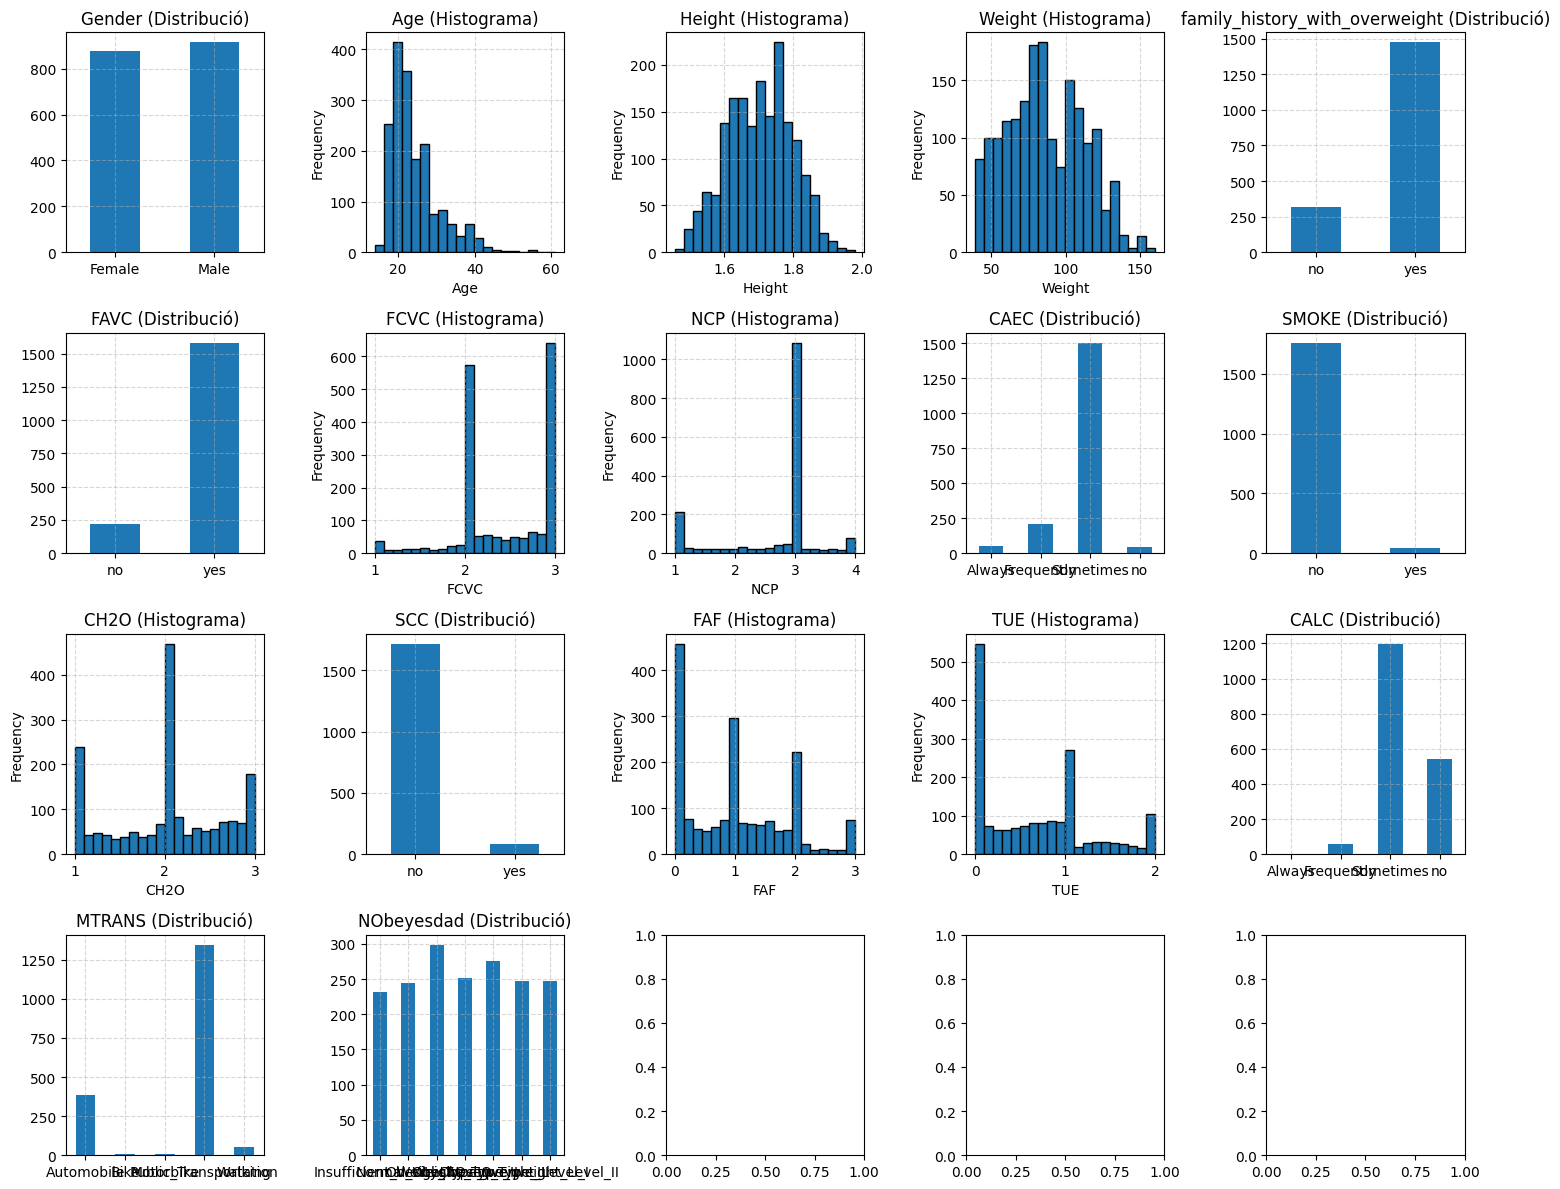

In [96]:
cols = df_split.columns.tolist()

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cols[:17]): 
    ax = axes[i]
    
    if (not pd.api.types.is_numeric_dtype(df_split[col])) or (df_split[col].nunique() <= 6):
        value_counts = df_split[col].value_counts().sort_index()
        value_counts.plot(kind='bar', ax=ax)
        ax.set_title(f'{col} (Distribució)')
        ax.set_xlabel('')
        ax.set_xticklabels(value_counts.index, rotation=0)
    
    else:
        df_split[col].plot(kind='hist', bins=20, edgecolor='black', ax=ax)
        ax.set_title(f'{col} (Histograma)')
        ax.set_xlabel(col)

    
    
    ax.grid(True, linestyle='--', alpha=0.5)

for j in range(i + 1, 17):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

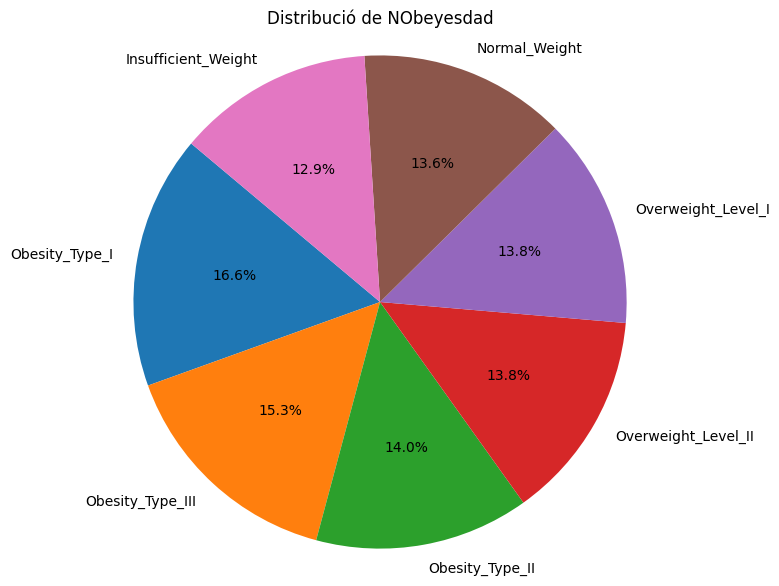

In [97]:
import matplotlib.pyplot as plt

counts = df_split['NObeyesdad'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribució de NObeyesdad')
plt.axis('equal')
plt.show()

In [98]:
df_split = pd.get_dummies(df_split, columns=['MTRANS'])
df_split.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
1994,Female,21.282238,1.748951,133.662583,yes,yes,3.000000,3.0,Sometimes,no,...,no,1.609938,0.849236,Sometimes,Obesity_Type_III,False,False,False,True,False
17,Female,29.000000,1.530000,78.000000,no,yes,2.000000,1.0,Sometimes,no,...,no,0.000000,0.000000,no,Obesity_Type_I,True,False,False,False,False
206,Male,19.000000,1.750000,100.000000,yes,yes,2.000000,3.0,Frequently,no,...,no,2.000000,0.000000,no,Obesity_Type_I,False,False,False,True,False
1944,Female,21.051982,1.729719,131.877558,yes,yes,3.000000,3.0,Sometimes,no,...,no,1.708971,0.673009,Sometimes,Obesity_Type_III,False,False,False,True,False
1198,Male,18.000000,1.750097,86.372141,yes,yes,2.907062,3.0,Sometimes,no,...,no,1.219827,0.037634,Sometimes,Overweight_Level_II,False,False,False,True,False


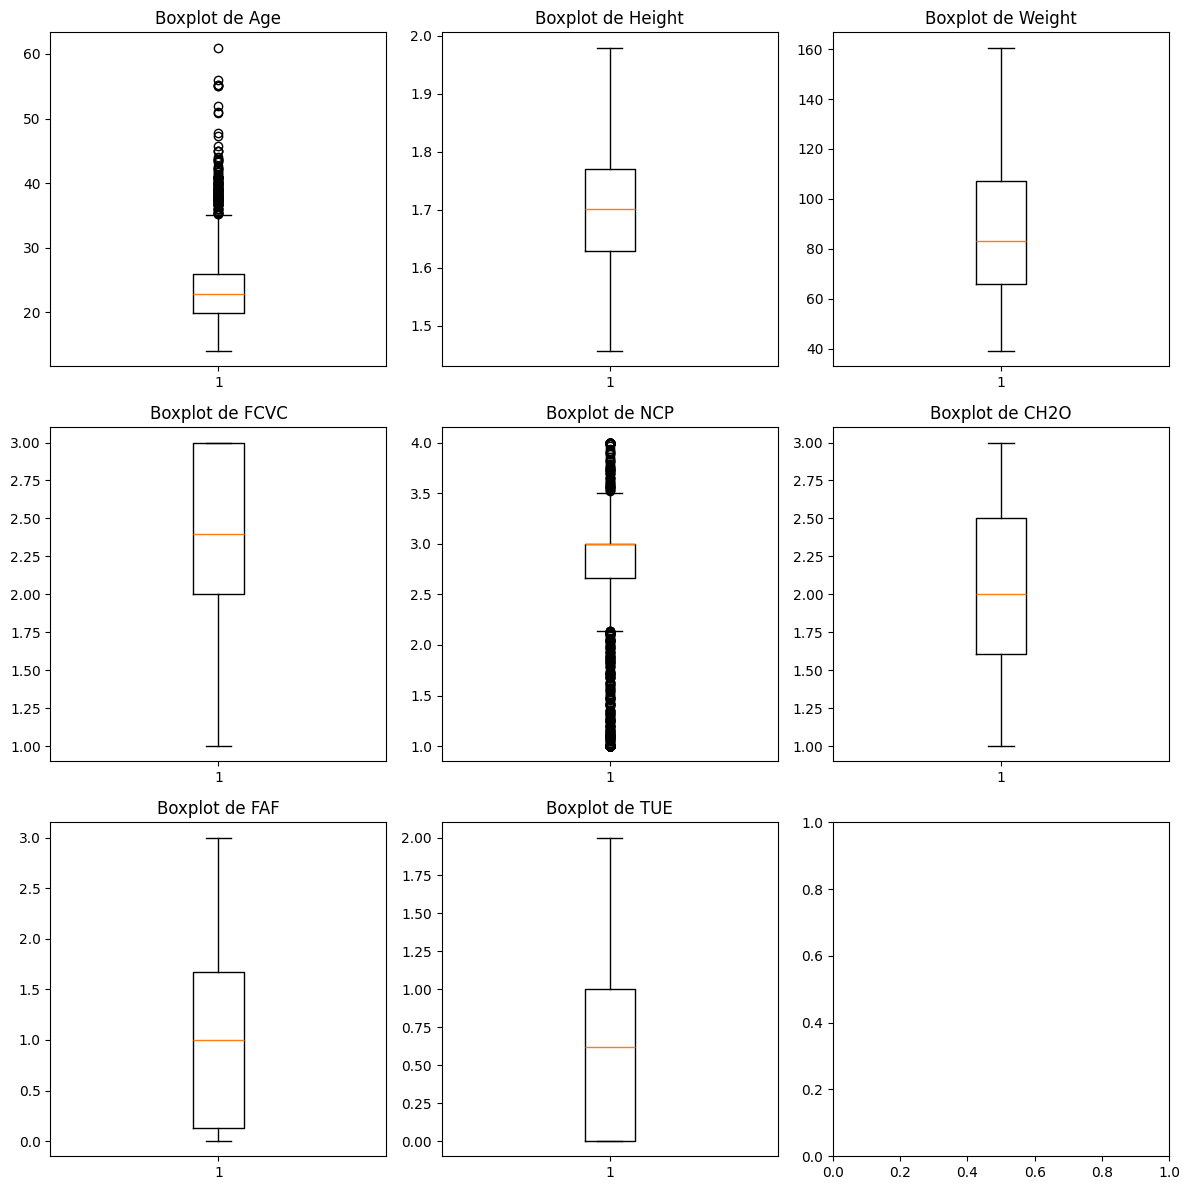

In [99]:
# Seleccionem només les variables numèriques
numeriques = df_split.select_dtypes(include=['float64', 'int64']).columns

# Definim la quadrícula 3x2
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3 files, 2 columnes
axes = axes.flatten()  # convertim a array 1D per iterar més fàcil

# Fem el boxplot per cada variable
for i, col in enumerate(numeriques[:8]):  # Només 6 variables per a 3x2
    axes[i].boxplot(df_split[col])
    axes[i].set_title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()

In [103]:
df_split['Gender'] = df_split['Gender'].replace({'Male': 1, 'Female': 0})
df_split['family_history_with_overweight'] = df_split['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
df_split['FAVC'] = df_split['FAVC'].replace({'yes': 1, 'no': 0})
df_split['SMOKE'] = df_split['SMOKE'].replace({'yes': 1, 'no': 0})
df_split['SCC'] = df_split['SCC'].replace({'yes': 1, 'no': 0})
df_split['CALC'] = df_split['CALC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})
df_split['CAEC'] = df_split['CAEC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})

C:\Users\annit\AppData\Local\Temp\ipykernel_37268\632722537.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_split['CAEC'] = df_split['CAEC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})


In [101]:
df_split.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
1994,0,21.282238,1.748951,133.662583,1,1,3.000000,3.0,Sometimes,0,...,0,1.609938,0.849236,1,Obesity_Type_III,False,False,False,True,False
17,0,29.000000,1.530000,78.000000,0,1,2.000000,1.0,Sometimes,0,...,0,0.000000,0.000000,0,Obesity_Type_I,True,False,False,False,False
206,1,19.000000,1.750000,100.000000,1,1,2.000000,3.0,Frequently,0,...,0,2.000000,0.000000,0,Obesity_Type_I,False,False,False,True,False
1944,0,21.051982,1.729719,131.877558,1,1,3.000000,3.0,Sometimes,0,...,0,1.708971,0.673009,1,Obesity_Type_III,False,False,False,True,False
1198,1,18.000000,1.750097,86.372141,1,1,2.907062,3.0,Sometimes,0,...,0,1.219827,0.037634,1,Overweight_Level_II,False,False,False,True,False


Regressió de la variable resposta

In [105]:
df_split['NObeyesdad'] = df_split['NObeyesdad'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})

C:\Users\annit\AppData\Local\Temp\ipykernel_37268\2853249978.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_split['NObeyesdad'] = df_split['NObeyesdad'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})


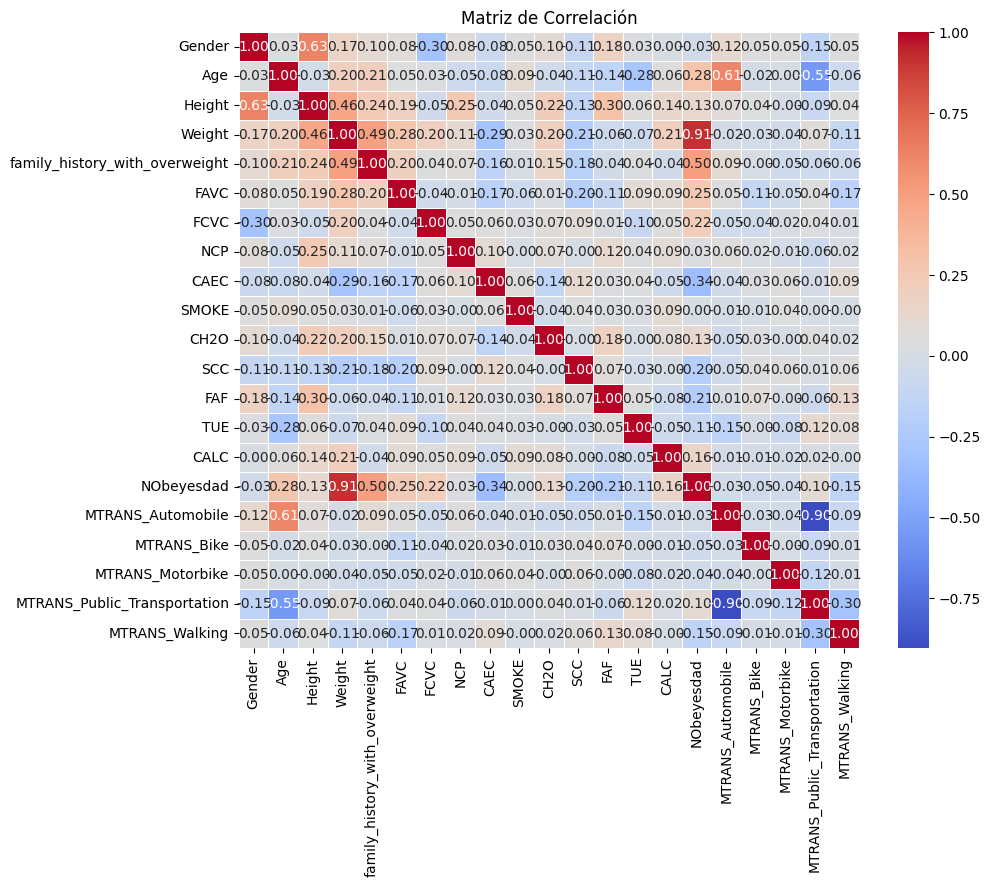

In [106]:
corr_matrix = df_split.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()